In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import time

In [2]:
# Define dataset paths
train_dir = "/kaggle/input/iris-data/Retinal fundus images for DR/1.train"
val_dir = "/kaggle/input/iris-data/Retinal fundus images for DR/2.val"
test_dir = "/kaggle/input/iris-data/Retinal fundus images for DR/3.test"

# Image data preprocessing
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# Custom classification head
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Found 638 images belonging to 7 classes.
Found 136 images belonging to 7 classes.
Found 143 images belonging to 7 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Train model
start_time = time.time()
history = model.fit(train_generator, validation_data=val_generator, epochs=10)
training_time = time.time() - start_time

# Evaluate Model
y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator), axis=1)
class_labels = list(train_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.2744 - loss: 2.0312 - val_accuracy: 0.5441 - val_loss: 1.3341
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5103 - loss: 1.3713 - val_accuracy: 0.5441 - val_loss: 1.2656
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5192 - loss: 1.2749 - val_accuracy: 0.5441 - val_loss: 1.2195
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5403 - loss: 1.3027 - val_accuracy: 0.5588 - val_loss: 1.1960
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 973ms/step - accuracy: 0.5378 - loss: 1.1883 - val_accuracy: 0.5441 - val_loss: 1.2343
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 998ms/step - accuracy: 0.5584 - loss: 1.1780 - val_accuracy: 0.5662 - val_loss: 1.1714
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 978ms/step - accuracy: 0.6009 - loss: 1.1319 - val_accuracy: 0.5809 - val_loss: 1.1612
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5568 - loss: 1.1809 - val_accuracy: 0.5662 - val_loss: 1

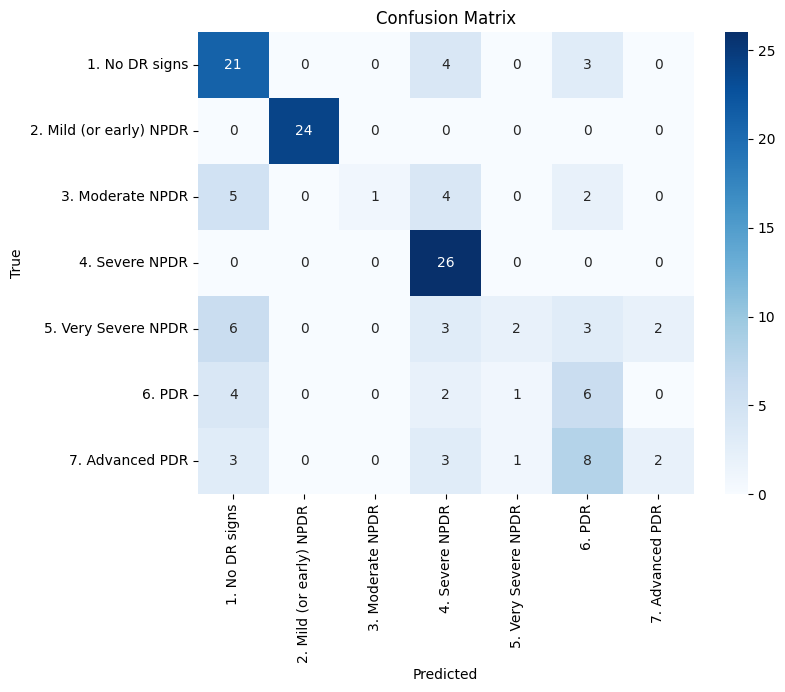

Training Time: 342.99 seconds
Accuracy: 0.6029
Precision: 0.6329
Recall (Sensitivity): 0.5054
F1-Score: 0.4684
Specificity: 0.8798


In [4]:

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Compute Metrics
TN = np.diag(cm).sum() - cm.sum(axis=0)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = TN / (TN + FP)
accuracy = np.trace(cm) / np.sum(cm)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {np.mean(precision):.4f}")
print(f"Recall (Sensitivity): {np.mean(recall):.4f}")
print(f"F1-Score: {np.mean(f1_score):.4f}")
print(f"Specificity: {np.mean(specificity):.4f}")